## Подготовка датасета

In [360]:
import math
import numpy as np
import pandas as pd 
import seaborn as sns
import seaborn.objects as so
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator

from matplotlib import pyplot as plt


Загрузим датасет с ирисами и уберем не нужный по заданию класс

In [361]:
iris = load_iris()
df = pd.DataFrame(
    data= np.c_[iris['data'], iris['target']],
    columns= iris['feature_names'] + ['target']
)
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

df = df[df['species'] != 'setosa']
df[ 'target' ] = df['target'] - 1 # Подправим классы, чтобы они лежали в пределах 0 и 1

df.sample(5, random_state=31337)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
104,6.5,3.0,5.8,2.2,1.0,virginica
147,6.5,3.0,5.2,2.0,1.0,virginica
71,6.1,2.8,4.0,1.3,0.0,versicolor
143,6.8,3.2,5.9,2.3,1.0,virginica
77,6.7,3.0,5.0,1.7,0.0,versicolor


Произведем разбивку датасета на обучающий и тестовый наборы

In [362]:
X = df.iloc[:, :-2]
y = df.iloc[:, 4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31337)

print( X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(80, 4) (80,) (20, 4) (20,)


In [363]:
def print_accuracy(model_name, model):
    print( f'{model_name} | train  |', accuracy_score( y_train, model.predict(X_train) ) )
    print( f'{model_name} | test   |', accuracy_score( y_test,  model.predict(X_test)  ) )

In [364]:
# Для быстрой настройки параметров во всех моделях

N_EPOCS=500
LEARNING_RATE=1/100

## Референс

Для референса, предоставим решение с помощью логистической регрессии из пакета `sklearn`

In [365]:
# Эталонное решение с помощью sklean

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score

sklearn_pipeline = make_pipeline(
    # Просто бахнем регрессией и все, без предобработки
    LogisticRegression(max_iter=N_EPOCS, random_state=31337, tol=LEARNING_RATE, solver='liblinear')
)

sklearn_pipeline.fit(X, y)
print_accuracy('SKLEARN', sklearn_pipeline)

SKLEARN | train  | 0.9625
SKLEARN | test   | 1.0


## Baseline

Сделаем небольшой baseline - оценщик, который будет всегда предсказывать только выбранный класс

In [366]:
class SingleClassEstimator(BaseEstimator):
    def __init__(self, selected_class = 0) -> None:
        self.selected_class = selected_class

    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        return np.full(shape=X.shape[0], fill_value=self.selected_class)
    
my_pipliene = make_pipeline(
    SingleClassEstimator(selected_class=0),
)

my_pipliene.fit(X, y)
print_accuracy('BASELINE_0', my_pipliene)

BASELINE_0 | train  | 0.5125
BASELINE_0 | test   | 0.45


В общем, как минимум ндао постараться сделать лучше!

## Реализация логистической регрессии своими силами

MY_LOGREG_1 | train  | 0.9625
MY_LOGREG_1 | test   | 1.0


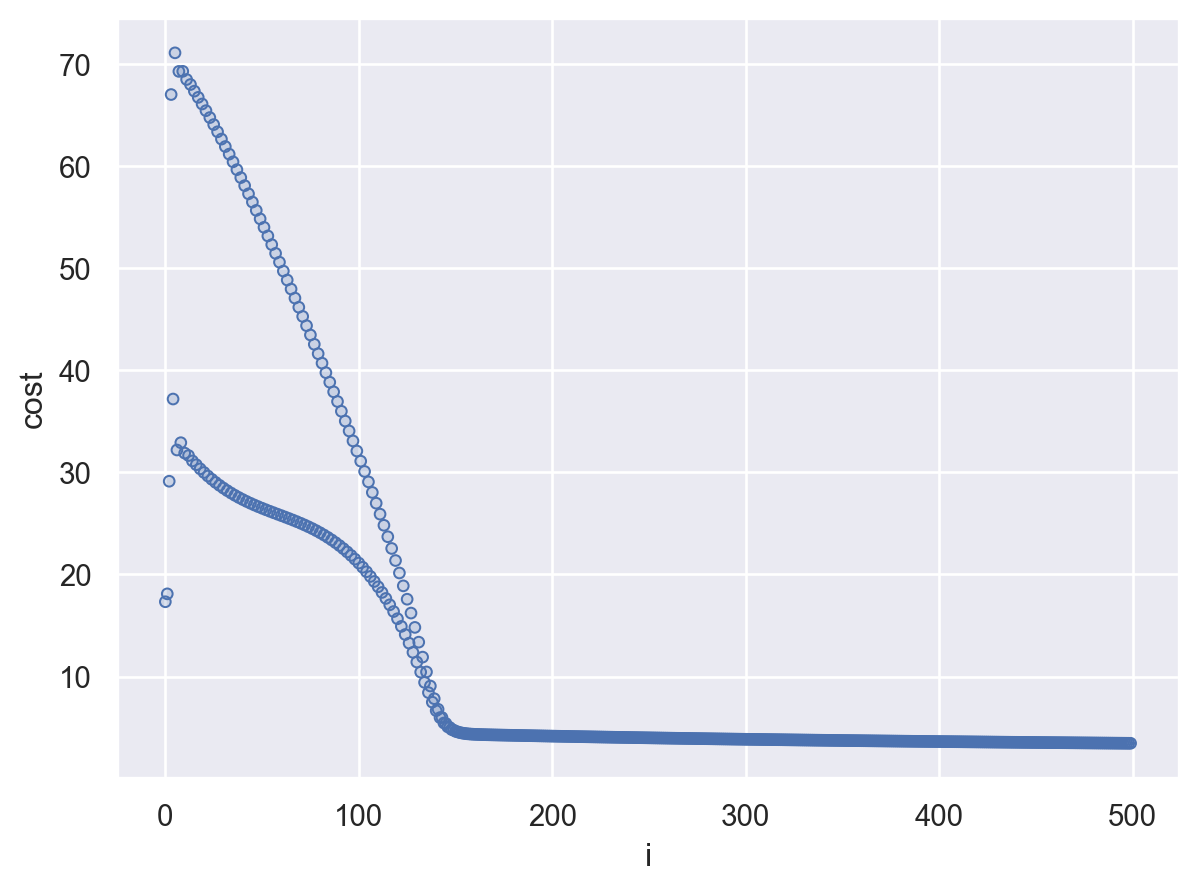

In [367]:
class MyLogisticRegresion(BaseEstimator):
    def __init__(self, max_iters=200, tol= 1/100) -> None:
        self.max_iters = max_iters
        self.tol       = tol

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y=None):
        n_samples  = X.shape[0]
        n_features = X.shape[1]

        self.W = np.zeros((n_features,))
        self.b = 0
        self.fit_iterations_ = []

        for i in range(0, self.max_iters):
            try:
                prediction = self._sigmoid( np.dot(X, self.W.T) + self.b )
                cost = -(1/n_features) * np.sum( (y * np.log(prediction)) + ((1-y) * np.log(1-prediction)) )
                if np.isinf(cost):
                    raise "INF"
                if np.isnan(cost):
                    raise "NAN"
                dw   =  (1/n_features) * np.dot(X.T, (prediction - y))
                db   =  (1/n_features) * np.sum(prediction - y)
                self.fit_iterations_.append( dict(i=i, cost=cost, dW=dw, W=self.W, b=self.b, dB=db ) )
                self.W = self.W - self.tol * dw
                self.b = self.b - self.tol * db
            except:
                break

        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        predictions = self._sigmoid( np.dot(X, self.W.T) + self.b )
        return np.round(predictions)
    
    def predict_proba(self, X):
        predictions = self._sigmoid( np.dot(X, self.W.T) + self.b )
        return predictions
    
my_pipliene = make_pipeline(
   MyLogisticRegresion(max_iters=N_EPOCS, tol=LEARNING_RATE)
)
my_pipliene.fit(X, y)

print_accuracy('MY_LOGREG_1', my_pipliene)

MY_LOGREG_1_iterations = pd.DataFrame(my_pipliene.steps[0][1].fit_iterations_)
#print(iterations)

(
    so.Plot()
        .add(so.Dots(), data=MY_LOGREG_1_iterations, y='cost',x ='i'  )
)

# DEBUG
# for l in my_pipliene.steps[0][1].fit_iterations_:
#     print(l['i'], l['cost'])

На графике заметно как функция потерь мечется вокруг локального минимума

## RMSProp

MY_RMSPORP_LOGREG_2 | train  | 0.9625
MY_RMSPORP_LOGREG_2 | test   | 1.0


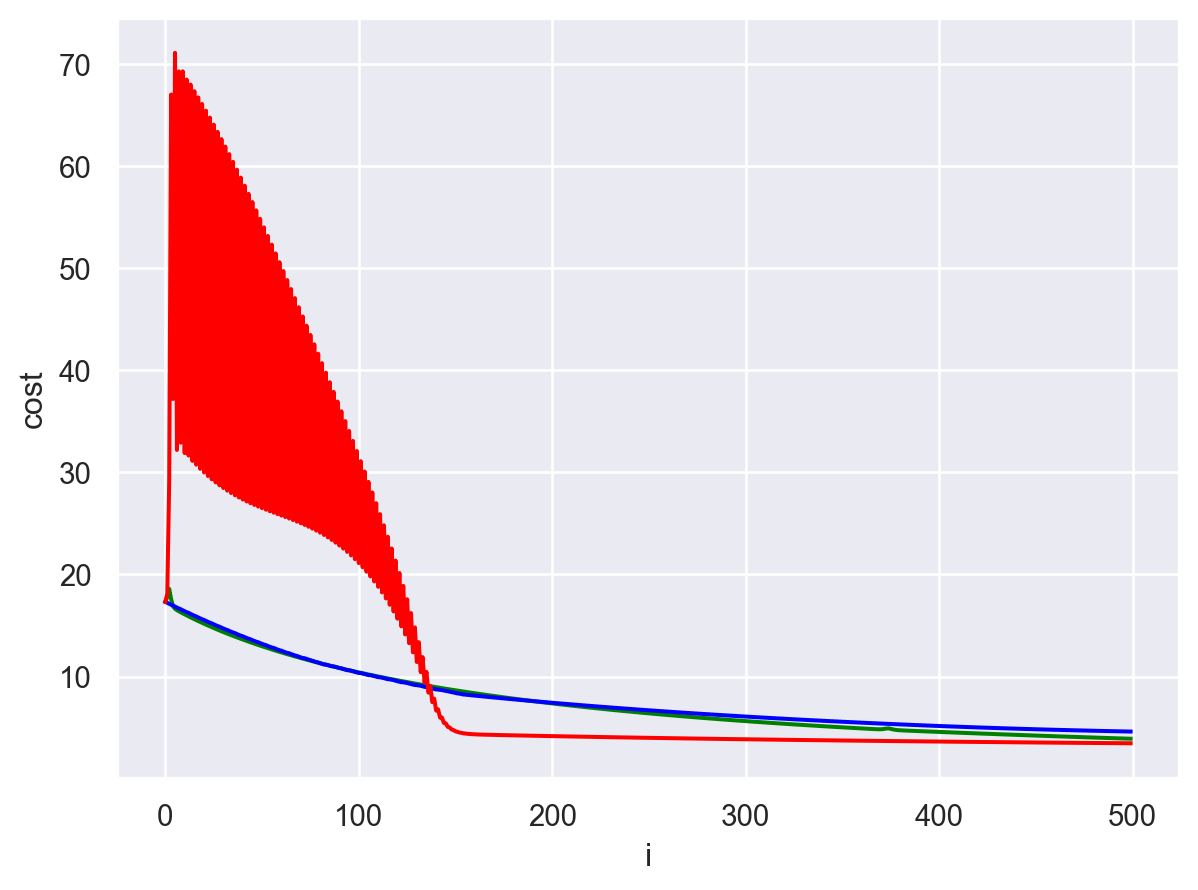

In [368]:
class MyRMSPropLogisticRegresion(BaseEstimator):
    def __init__(self, max_iters=200, tol= 1/100, decay=0.001) -> None:
        self.max_iters = max_iters
        self.tol       = tol
        self.decay     = decay

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y=None):
        n_samples  = X.shape[0]
        n_features = X.shape[1]

        self.W = np.zeros((n_features,))
        self.b = 0
        
        self.rms_dW = np.ones_like(self.W)
        self.rms_db = 0

        self.fit_iterations_ = []

        for i in range(0, self.max_iters):
            try:
                prediction = self._sigmoid( np.dot(X, self.W.T) + self.b )
                cost = -(1/n_features) * np.sum( (y * np.log(prediction)) + ((1-y) * np.log(1-prediction)) )
                
                if np.isinf(cost):
                    raise "INF"
                if np.isnan(cost):
                    raise "NAN"
                
                dw   =  (1/n_features) * np.dot(X.T, (prediction - y))
                db   =  (1/n_features) * np.sum(prediction - y)

                # Расчет экспоненциально взвешенных средних квадратов градиентов
                self.rms_dW = self.decay * self.rms_dW + (1 - self.decay) * dw**2
                self.rms_db = self.decay * self.rms_db + (1 - self.decay) * db**2
                
                # print( self.rms_db, self.rms_dW )

                self.fit_iterations_.append( dict(i=i, cost=cost, dW=dw, W=self.W, b=self.b, dB=db, rmsdW = self.rms_dW, rmsdB = self.rms_db ) )

                self.W = self.W - self.tol * dw / (np.sqrt(self.rms_dW) + 0.00000001 )
                self.b = self.b - self.tol * db / (np.sqrt(self.rms_db) + 0.00000001 )
            except:
                break

        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        predictions = self._sigmoid( np.dot(X, self.W.T) + self.b )
        return np.round(predictions)
    
    def predict_proba(self, X):
        predictions = self._sigmoid( np.dot(X, self.W.T) + self.b )
        return predictions
    
my_pipliene = make_pipeline(
   MyRMSPropLogisticRegresion(max_iters=N_EPOCS, tol=LEARNING_RATE, decay=0.01)
)
my_pipliene.fit(X, y)

print_accuracy('MY_RMSPORP_LOGREG_2', my_pipliene)

MY_RMSPORP_LOGREG_2_iterations = pd.DataFrame(my_pipliene.steps[0][1].fit_iterations_)
#print(iterations)

rms_big_decay = make_pipeline(
   MyRMSPropLogisticRegresion(max_iters=N_EPOCS, tol=LEARNING_RATE, decay=0.99)
)
rms_big_decay.fit(X, y)
MY_RMSPORP_LOGREG_BIG_DECAY_iterations = pd.DataFrame(rms_big_decay.steps[0][1].fit_iterations_)

(
    so.Plot()
        .add(so.Lines(color='green'), data=MY_RMSPORP_LOGREG_BIG_DECAY_iterations, y='cost', x = 'i'  )
        .add(so.Lines(color='blue'),  data=MY_RMSPORP_LOGREG_2_iterations,         y='cost', x = 'i'  )
        .add(so.Lines(color='red'),   data=MY_LOGREG_1_iterations,                 y='cost', x = 'i'  )
)